In [2]:
import mdtraj as md
import glob
import seaborn as sbn
import nglview as nv
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook

Read in the VR trajectories

In [3]:
vr_trajs = [] 
native_top = md.load_pdb("../cypa.pdb")
filenames = glob.glob("*_100s_*.dcd")
for dcd in filenames:
    traj = md.load_dcd(dcd, top = "../cypa_traj.pdb")
    vr_trajs.append(traj)

## Frame Selection

We'll use clustering to select frames based on the features gathered from PCA, see cypa_simbox_analysis

In [4]:
traj = md.join(vr_trajs)
print(traj.n_frames)
output_frames = 15

282


In [9]:
contacts_res = [[ 69, 101],  [ 82, 102], [ 82,  73]]
pairwise_distances, pairs = md.compute_contacts(traj, contacts_res, scheme='closest')
print(pairwise_distances.shape)

(282, 3)


We'll just use K-means as a proof of principle, one could imagine there might be better clustering algorithms to use! 

<IPython.core.display.Javascript object>


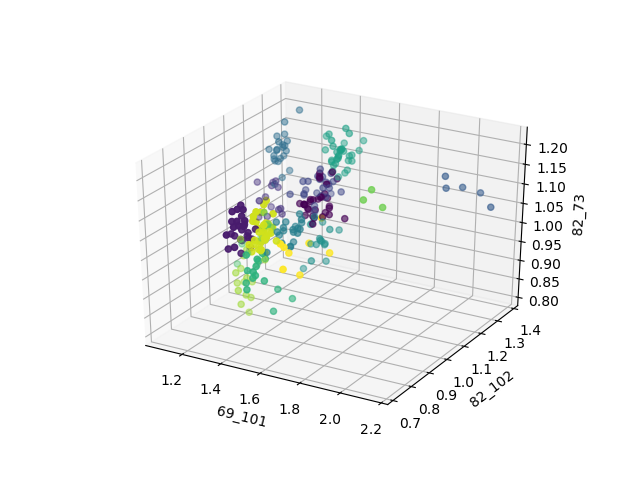

In [10]:
from sklearn.cluster import *
kmeans = KMeans(n_clusters=output_frames, n_init=100).fit(pairwise_distances)
clusters = kmeans.predict(pairwise_distances)
# compute the mean of each cluster.
cluster_centers = kmeans.cluster_centers_

if len(pairs) == 3:
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pairwise_distances[:,0],pairwise_distances[:,1], pairwise_distances[:,2], c=clusters.astype(np.float), marker='o')
    ax.set_xlabel(str.format("{0}_{1}",pairs[0][0], pairs[0][1]))
    ax.set_ylabel(str.format("{0}_{1}",pairs[1][0], pairs[1][1]))
    ax.set_zlabel(str.format("{0}_{1}",pairs[2][0], pairs[2][1]))


plt.show()

Sample a single instance from each cluster, this way we sample evenly across explored space rather than getting lots of commonly visited states

In [11]:
samples = []
for i in range(kmeans.n_clusters):
    # indices of all the points that belong to cluster
    C_i = np.where(kmeans.labels_ == i)[0].tolist() 
    n_i = len(C_i) # number of points in cluster i

    # indices of the points from X to be sampled from cluster i
    sample_i = np.random.choice(C_i) 
    print(i, sample_i)
    samples.append(sample_i)

0 235
1 19
2 73
3 91
4 180
5 47
6 202
7 249
8 122
9 186
10 151
11 178
12 169
13 23
14 176


<IPython.core.display.Javascript object>


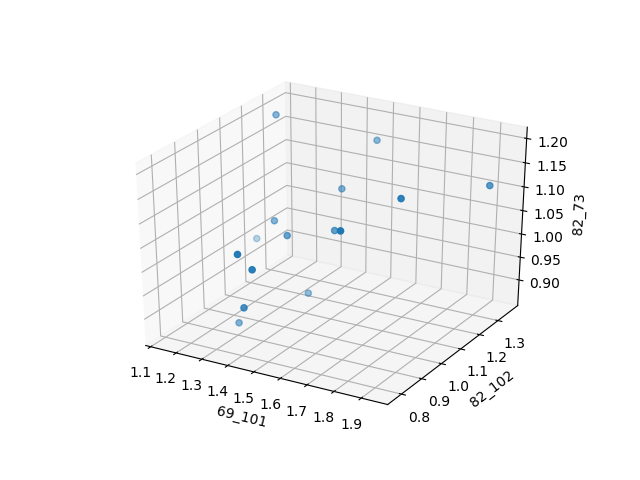

In [12]:
if len(pairs) == 3:
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pairwise_distances[:,0][samples],pairwise_distances[:,1][samples], pairwise_distances[:,2][samples], marker='o')
    ax.set_xlabel(str.format("{0}_{1}",pairs[0][0], pairs[0][1]))
    ax.set_ylabel(str.format("{0}_{1}",pairs[1][0], pairs[1][1]))
    ax.set_zlabel(str.format("{0}_{1}",pairs[2][0], pairs[2][1]))


plt.show()

In [27]:
import os
directory = 'initial_conditions'
if not os.path.exists(directory):
    os.makedirs(directory)
for frame in samples:
    traj[frame].save_pdb(str.format("{0}/cypa_{1}.pdb",directory,frame))